In [218]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyomo.opt import SolverFactory

In [219]:
# data
data = pd.read_excel('inputs.xlsx')

In [220]:
def solve_opt(data, pass_min=0, pass_max=5990, mult_1=1, mult_2=1, tee=False):
    model = pyo.ConcreteModel()  # create model
    # vary mult 1 to create pareto front!!!
    t = 96
    k = 100
    D_passenger = (data['Total demand'] * mult_1).tolist()
    O_energy = (data['Outage'] * mult_2).tolist()
    Riding_price = 0.5
    P_buy = 0.1
    P_sell = 0.6
    alpha = 10
    beta = 7.2
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = 1.5  # 30km/h
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    R_bat = 150
    C_bat = 80
    Cycle = 3000
    DoD = 60
    T = 96
    delta_t = 0.25

    # sets
    model.T = pyo.RangeSet(t)  # set of timesteps
    model.K = pyo.RangeSet(k)  # set of SAEVs

    # parameters
    model.D_passenger = pyo.Param(model.T, initialize=lambda model, t: D_passenger[t-1])
    model.O_energy = pyo.Param(model.T, initialize=lambda model, t: O_energy[t-1])
    
    # binary variables
    model.b = pyo.Var(model.K, model.T, within=pyo.Binary)  # serving trip indicator
    model.x = pyo.Var(model.K, model.T, domain=pyo.Binary)    # charging indicator
    model.y = pyo.Var(model.K, model.T, domain=pyo.Binary)    # discharging indicator

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals)  # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals)  # electricity sold to the grid at time t
    model.w_riding = pyo.Var(model.T, within=pyo.NonNegativeReals)  # number of trips performed at time t
    model.d = pyo.Var(model.T, within=pyo.NonNegativeReals)  # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()  # Create a set of constraints

    # Each vehicle can perform at most one action at each timestep
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.b[k, t] + model.x[k, t] + model.y[k, t] <= 1)
            
    # NEW CONSTRAINT: In the first time step, all vehicles should be charging.
    for k in model.K:
        model.constraints.add(model.x[k, 1] == 1)
        model.constraints.add(model.b[k, 1] == 0)
        model.constraints.add(model.y[k, 1] == 0)

    # Constraint for passenger demand (for each time step)
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) <= model.D_passenger[t])
    
    # The number of trips performed equals the number of vehicles serving at time t
    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) == model.w_riding[t])
    
    # Passenger bounds
    model.constraints.add(sum(model.w_riding[t] for t in model.T) >= pass_min)
    model.constraints.add(sum(model.w_riding[t] for t in model.T) <= pass_max)

    # Energy update constraint for t>=2
    for k in model.K:
        for t in range(2, T + 1):
            model.constraints.add(model.e[k, t] == model.e[k, t-1] + delta_t * ch_eff * alpha * model.x[k, t] 
                                  - gama * model.b[k, t] - delta_t * dch_eff * beta * model.y[k, t])

    # Grid power balance for charging
    for t in model.T:
        model.constraints.add(delta_t * sum(ch_eff * alpha * model.x[k, t] for k in model.K) == model.w_buy[t])
    
    # Grid power balance for discharging
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) == model.w_sell[t])
    
    # Outage power limit
    for t in model.T:
        model.constraints.add(delta_t * sum(dch_eff * beta * model.y[k, t] for k in model.K) <= delta_t * model.O_energy[t])
    
    # Battery energy limits
    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k, t] >= C_bat * E_min)
            model.constraints.add(model.e[k, t] <= C_bat * E_max)
    
    # Initial energy level and degradation cost
    for k in model.K:
        model.constraints.add(model.e[k, 1] == E_0 * C_bat)
    for t in model.T:
        model.constraints.add(model.d[t] == (R_bat / (Cycle * DoD)) * model.w_sell[t])

    # objective function
    def rule_obj(mod):
        return (sum(Riding_price * mod.w_riding[t] for t in mod.T) 
                - sum(P_buy * mod.w_buy[t] for t in mod.T) 
                + sum(P_sell * mod.w_sell[t] for t in mod.T)
                - sum(mod.d[t] for t in mod.T))
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.maximize)
    
    # SOLVER
    opt = pyo.SolverFactory('gurobi')
    opt.options['timelimit'] = 600
    opt.options['mipgap'] = 0.01
    results = opt.solve(model, tee=tee)
    print(results)
    return model


In [221]:
import matplotlib.pyplot as plt
import pyomo.environ as pyo

def plot_variables(model, D_passenger, O_energy, t=96, k=100):
    """
    Plots various variables from the Pyomo model, using a clean style
    on a white background, minimal grid, and a custom colour palette.
    Titles are removed, and legends include a border and are positioned
    below the chart.
    """

    # ============= STYLING PREFERENCES =============
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.grid': True,        # Enable grid
        'grid.alpha': 0.4,        # Grid line transparency
        'grid.linestyle': '-',    # Solid grid lines
        'grid.color': 'gray',     # Grid line colour
        'axes.axisbelow': True,   # Grid lines go behind data
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11,
        'lines.linewidth': 2,
    })

    # Define a new custom colour palette
    SERVING_COLOR       = '#2E8B57'  # SeaGreen
    CHARGING_COLOR      = '#FF8C00'  # DarkOrange
    DISCHARGING_COLOR   = '#4682B4'  # SteelBlue
    IDLE_COLOR          = '#8A2BE2'  # BlueViolet
    TOTAL_ENERGY_COLOR  = '#FFD700'  # Gold
    W_BUY_COLOR         = '#DC143C'  # Crimson
    W_SELL_COLOR        = '#00CED1'  # DarkTurquoise
    PASSENGER_COLOR     = '#808080'  # Grey
    OUTAGE_COLOR        = '#FF1493'  # DeepPink

    # Convert time steps to hours (assuming each step is 15 minutes)
    time_steps = range(1, t + 1)
    hours = [step / 4 for step in time_steps]
    bar_width = 0.2  # Width for bar charts

    # Retrieve data from the model
    serving = [sum(pyo.value(model.b[k, t]) for k in model.K) for t in model.T]
    charging = [sum(pyo.value(model.x[k, t]) for k in model.K) for t in model.T]
    discharging = [sum(pyo.value(model.y[k, t]) for k in model.K) for t in model.T]
    idle = [k - s - c - d for s, c, d in zip(serving, charging, discharging)]
    total_energy = [sum(pyo.value(model.e[k, t]) for k in model.K) for t in model.T]
    w_buy = [pyo.value(model.w_buy[t]) for t in model.T]
    w_sell = [pyo.value(model.w_sell[t]) for t in model.T]
    serving_percentage = [(sum(pyo.value(model.b[k, t]) for k in model.K) / k) * 100 for t in model.T]
    discharging_percentage = [(sum(pyo.value(model.y[k, t]) for k in model.K) / k) * 100 for t in model.T]

    # ============= 1. Fleet Status Over Time =============
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    ax.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax.bar(hours, serving, width=bar_width, color=SERVING_COLOR, label='Serving')
    ax.bar(hours, charging, width=bar_width, bottom=serving, color=CHARGING_COLOR, label='Charging')
    ax.bar(hours, discharging, width=bar_width,
           bottom=[s + c for s, c in zip(serving, charging)], color=DISCHARGING_COLOR, label='Discharging')
    ax.bar(hours, idle, width=bar_width,
           bottom=[s + c + d for s, c, d in zip(serving, charging, discharging)], color=IDLE_COLOR, label='Idle')
    ax.set_xlabel('Time [h]', color='black')
    ax.set_ylabel('Number of Vehicles', color='black')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    legend = ax.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()

    # ============= 2. Total Energy Level of the Fleet =============
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    ax.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax.plot(hours, total_energy, color=TOTAL_ENERGY_COLOR, label='Total Energy')
    ax.set_xlabel('Time [h]', color='black')
    ax.set_ylabel('Energy [kWh]', color='black')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    legend = ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()

    # ============= 3. Charging and Discharging Power Over Time =============
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    ax.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax.plot(hours, w_buy, color=W_BUY_COLOR, label='Charging (G2V)')
    ax.plot(hours, w_sell, color=W_SELL_COLOR, label='Discharging (V2G)')
    ax.set_xlabel('Time [h]', color='black')
    ax.set_ylabel('Power [kW]', color='black')
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 1))
    legend = ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()

    # ============= 4. Vehicles Serving (%) vs Passenger Demand =============
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)
    ax1.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax1.bar(hours, serving_percentage, width=bar_width, color=SERVING_COLOR, label='Vehicles Serving (%)')
    ax1.set_xlabel('Time [h]', color='black')
    ax1.set_ylabel('Vehicles [%]', color='black')
    ax1.set_ylim(bottom=0)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    ax2 = ax1.twinx()
    ax2.plot(hours, D_passenger, color=PASSENGER_COLOR, linestyle='-', label='Passenger Demand')
    ax2.set_ylabel('Number of Passengers', color='black')
    ax2.set_ylim(bottom=0)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                        ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()

    # ============= 5. Vehicles Discharging (%) vs Outage Demand =============
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)
    ax1.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax1.bar(hours, discharging_percentage, width=bar_width, color=DISCHARGING_COLOR, label='Vehicles Discharging (%)')
    ax1.set_xlabel('Time [h]', color='black')
    ax1.set_ylabel('Vehicles [%]', color='black')
    ax1.set_ylim(bottom=0)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    ax2 = ax1.twinx()
    ax2.plot(hours, O_energy, color=OUTAGE_COLOR, linestyle='-', label='Outage Demand')
    ax2.set_ylabel('Power Demand [kW]', color='black')
    ax2.set_ylim(bottom=0)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                        ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()

    # ============= 6. Vehicles Serving vs Power Delivered to the Grid =============
    fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)
    ax1.grid(axis='y', linestyle='-', alpha=0.4, color='gray')
    ax1.plot(hours, serving, color=SERVING_COLOR, label='Vehicles Serving')
    ax1.set_xlabel('Time [h]', color='black')
    ax1.set_ylabel('Number of Vehicles', color='black')
    ax1.set_ylim(bottom=0)
    ax1.set_xlim(0, 24)
    ax1.set_xticks(range(0, 25, 1))
    ax2 = ax1.twinx()
    ax2.plot(hours, w_sell, color=W_SELL_COLOR, linestyle='-', label='Power Delivered (V2G)')
    ax2.set_ylabel('Power [kW]', color='black')
    ax2.set_ylim(bottom=0)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                        ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.35), frameon=True)
    legend.get_frame().set_edgecolor('black')
    fig.tight_layout()
    plt.show()



In [222]:
model = solve_opt(data,mult_2=1,tee=True) # vary pass_min=2000 mult_2=0 (transportation scenario)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Read LP format model from file /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmpe3wa44r8.pyomo.lp
Reading time = 0.18 seconds
x1: 39278 rows, 38784 columns, 144572 nonzeros
Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[rosetta2] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39278 rows, 38784 columns and 144572 nonzeros
Model fingerprint: 0x34fcb25d
Variable types: 9984 continuous, 28800 integer (28800 binary)
Coefficient statistics:
  Matrix range     [8e-04, 2e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Found heuristic solution: objective -22.5000000
Presolve removed 20459 rows and 5682 columns
Presolve time: 0.17s
Presolved: 18819 rows, 33102 columns

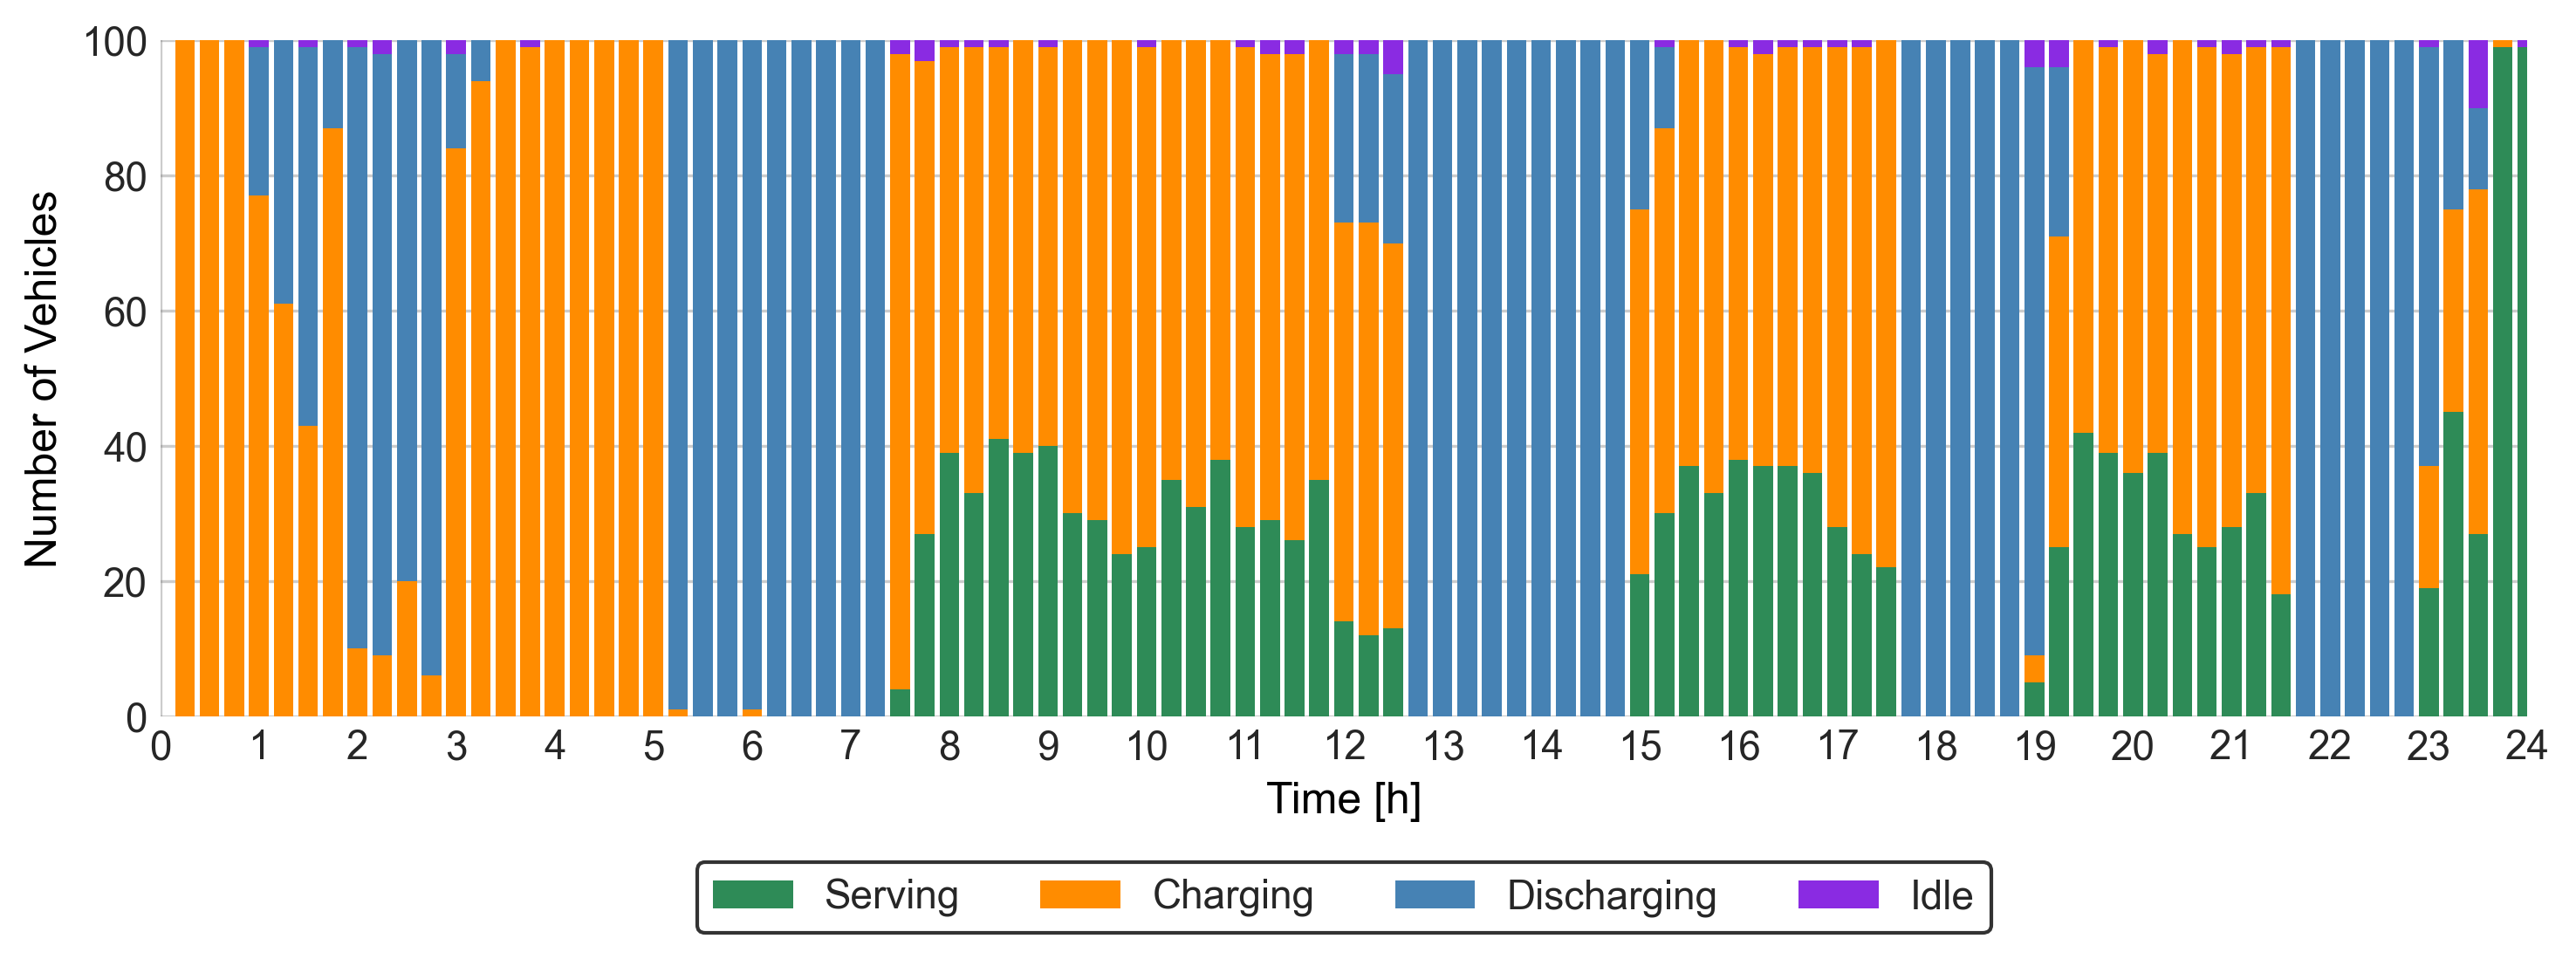

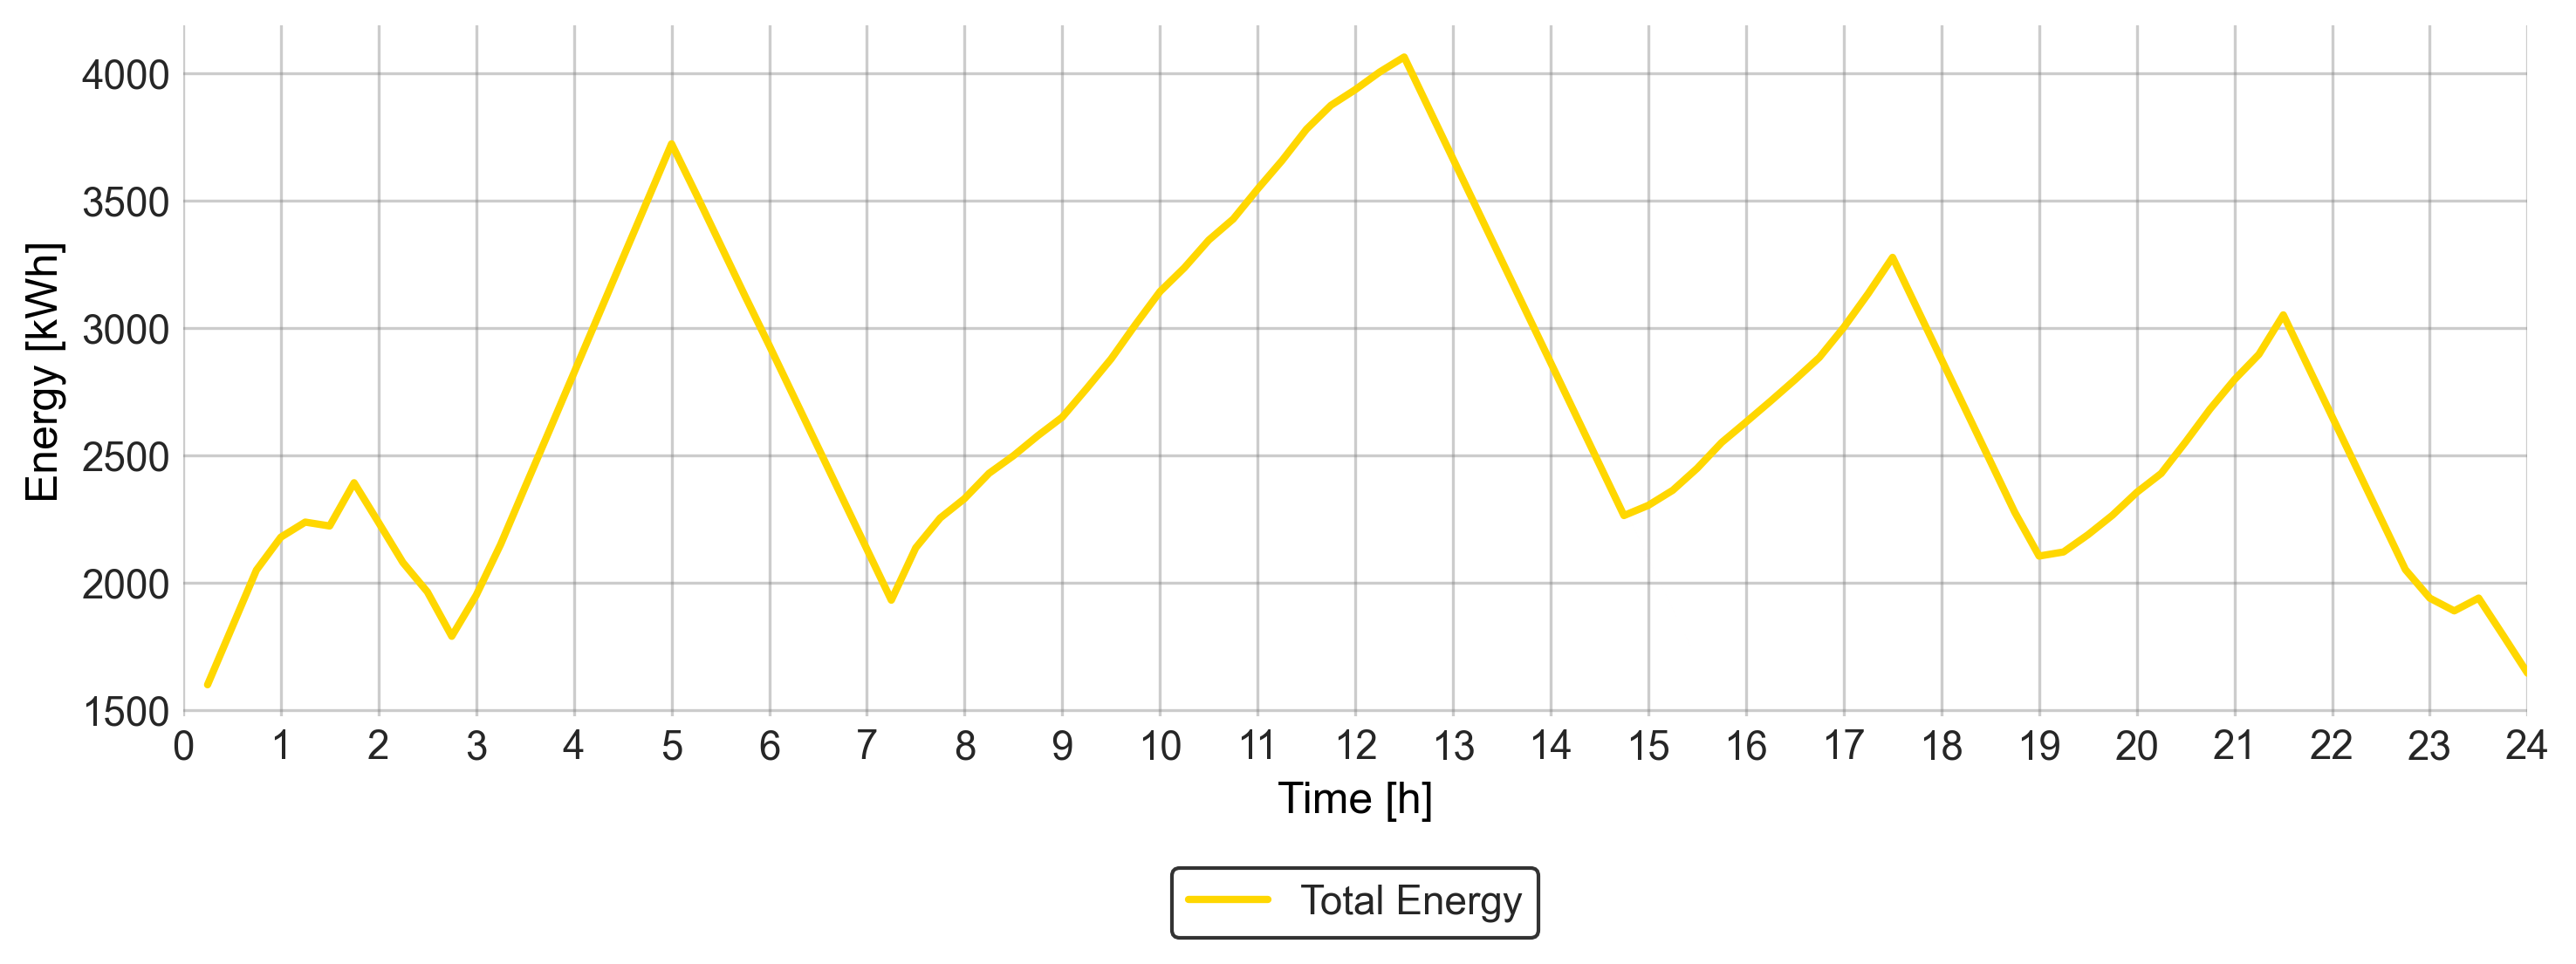

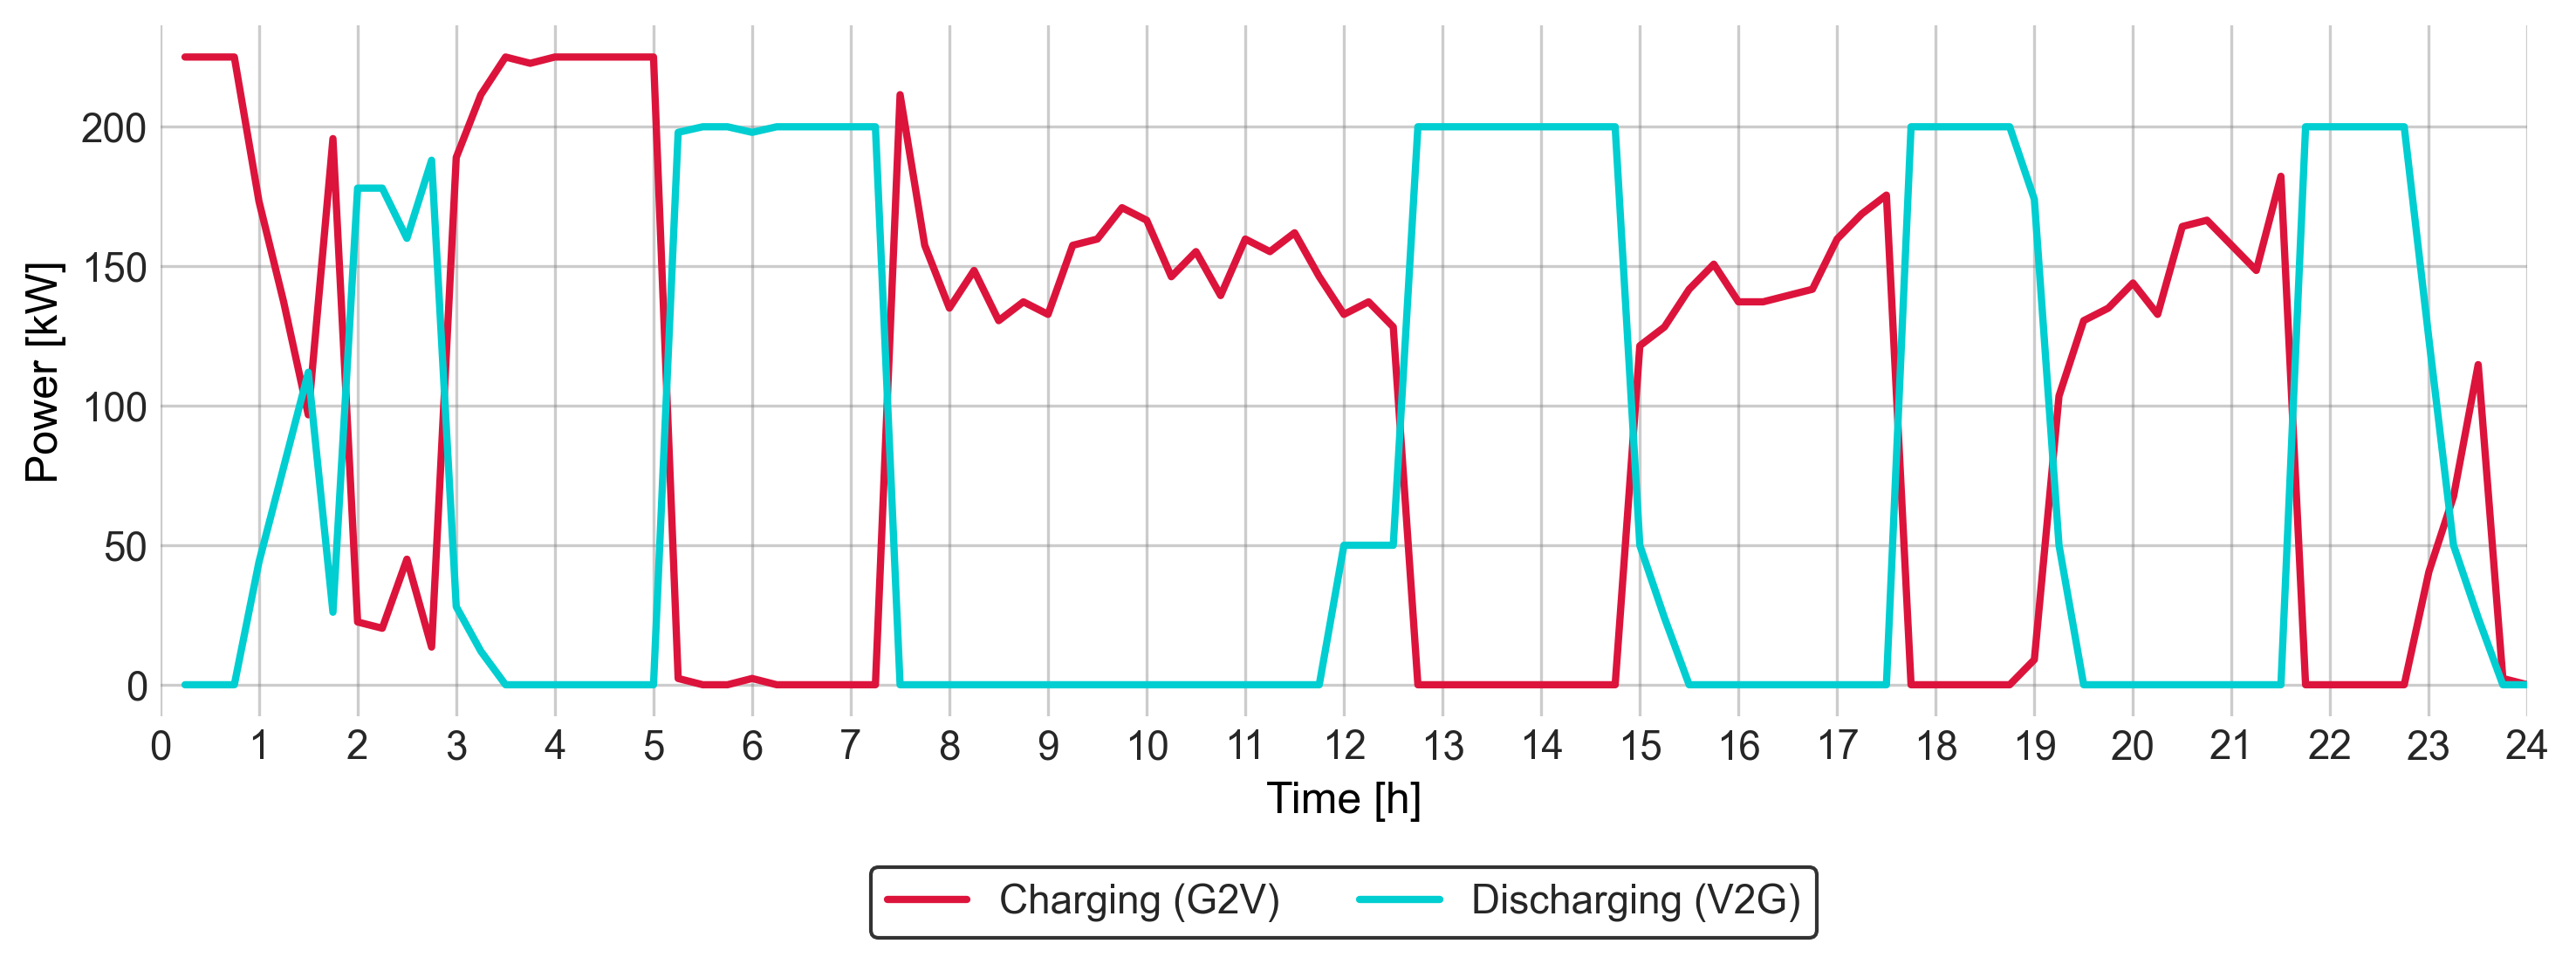

ValueError: x and y must have same first dimension, but have shapes (96,) and (102,)

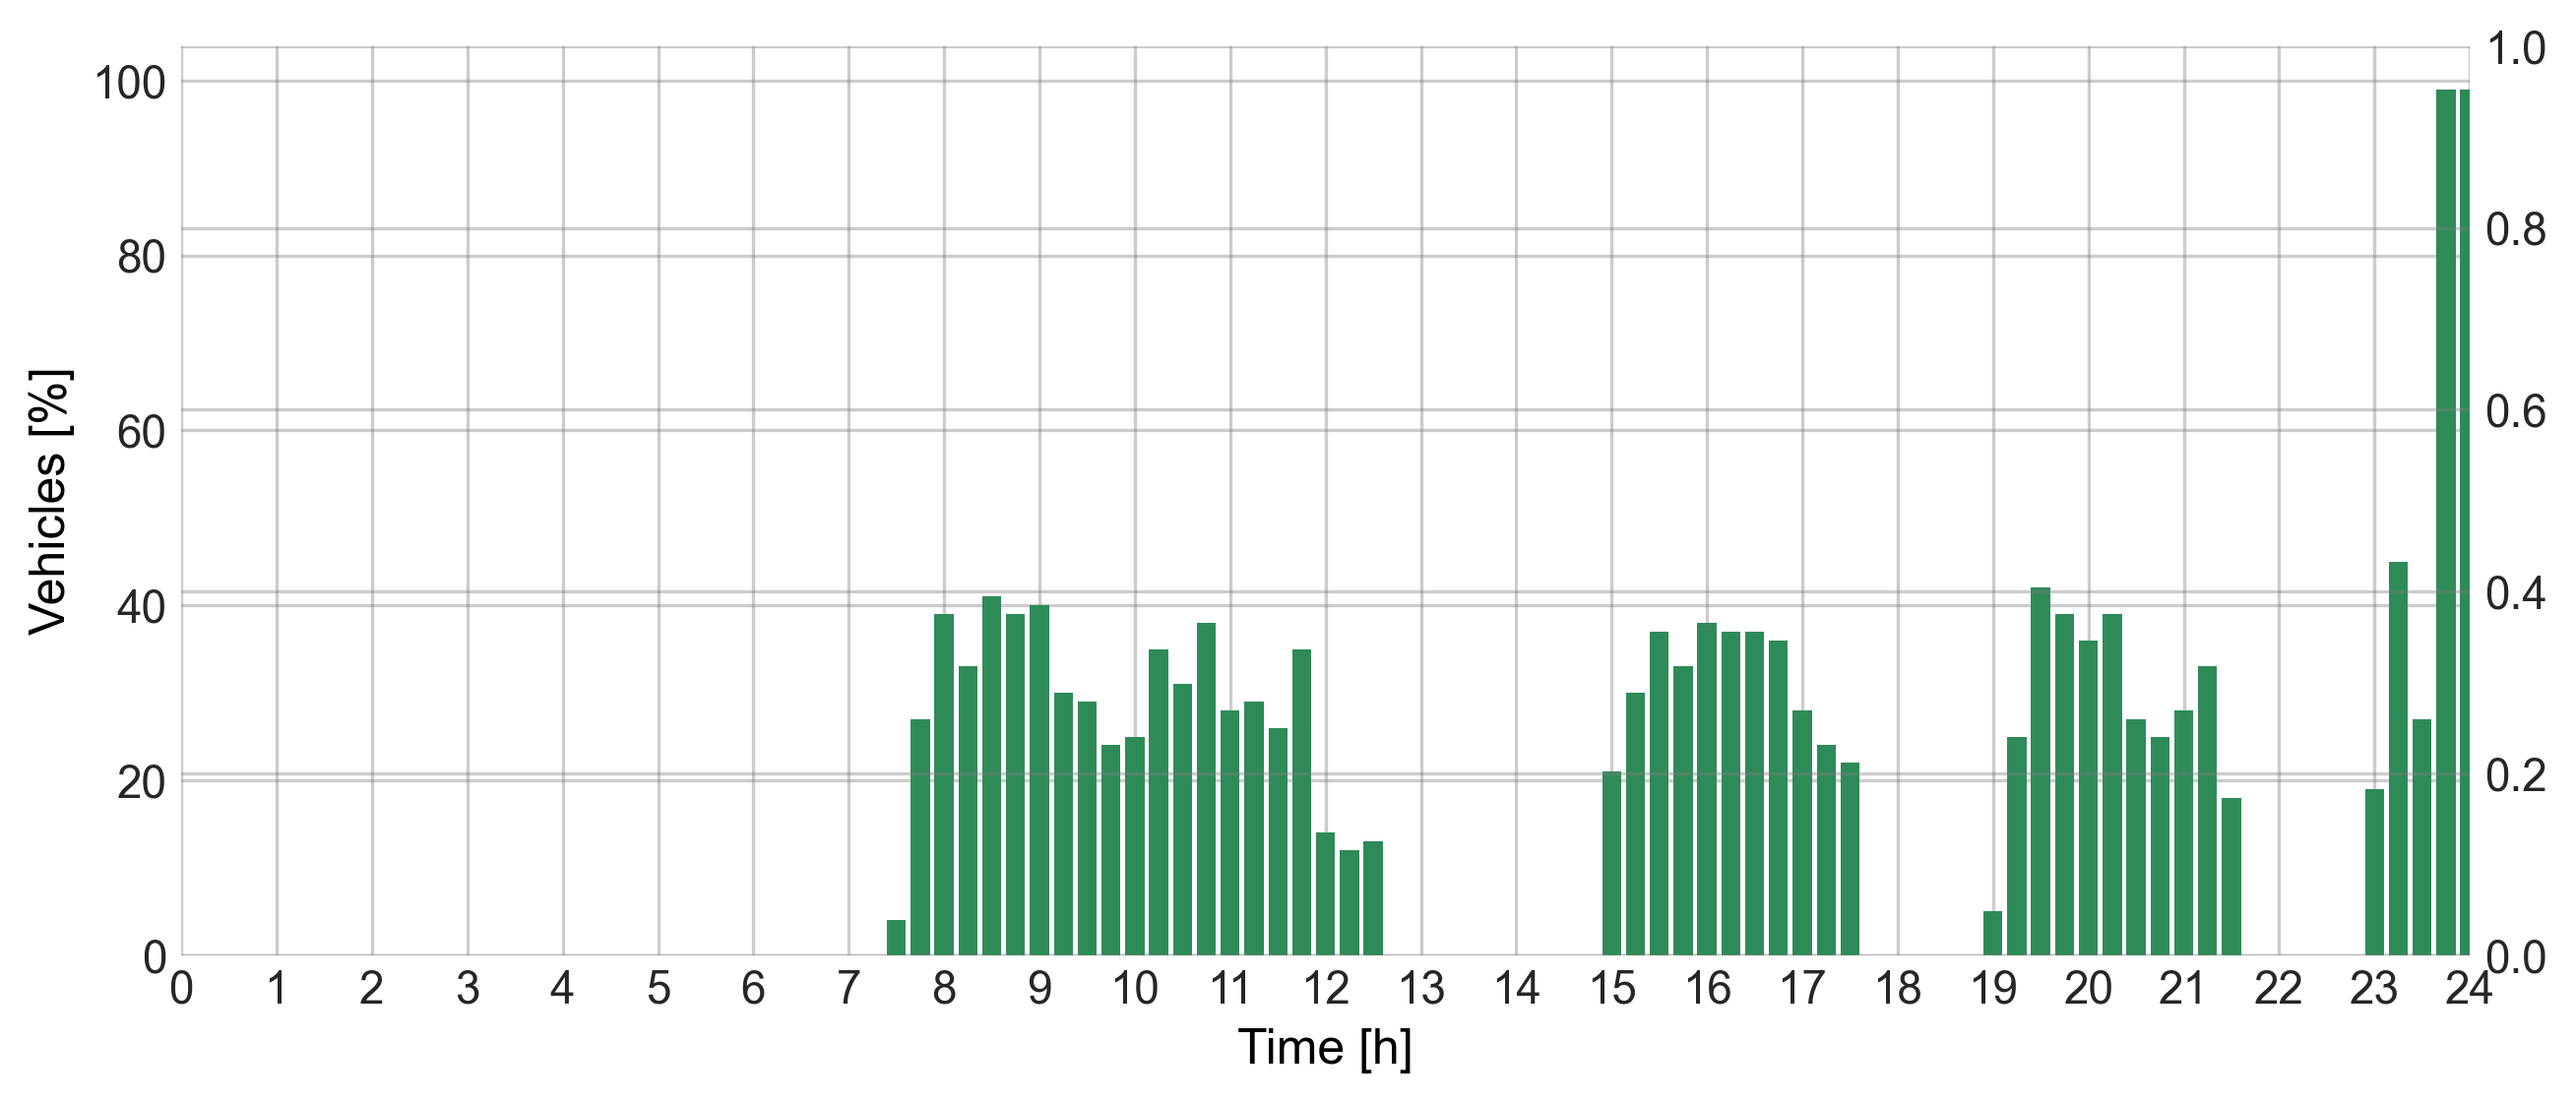

In [223]:
D_passenger = (data['Total demand']).tolist()
O_energy = (data['Outage']).tolist()
plot_variables(model, D_passenger, O_energy)

In [224]:
# Create a dynamic filename
filename = 'output_test.xlsx'
# Save results to Excel
save_to_excel(model, filename=filename)